In [1]:
# standard imports
import numpy as np
import pandas as pd
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
#import pygmt
from pyproj import Proj, Geod
from osgeo import gdal

import sys
sys.path.append('/Users/chanagan/Documents/GitHub/ImageryResources/Functions/')
import TiffTools as tt


# user-defined imports
import tdcalc

# reload modules when changed
%reload_ext autoreload
%autoreload 2

**Note that the files have been shifted around after creation, proceed with a critical reading eye**

In [2]:
projfolder = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/'

In [4]:
P = Proj('epsg:32611')
G = Geod(ellps='WGS84')

In [8]:
tracedf = pd.read_csv(projfolder+'GIS/EastPoints.csv')
# Project to UTM
tracedf['x'], tracedf['y'] = P(tracedf.Lon, tracedf.Lat)


In [9]:
# Extend the points to depth
pts = []
# Add all surface points and edge points at depth,
# but skip every other so that 
# there are fewer triangles
for i in range(0,len(tracedf)):
    pts.append([tracedf.x.iloc[i], tracedf.y.iloc[i], 0])
# Edges
for i in [0,-1]:
    for d in range(1,6):
        pts.append([tracedf.x.iloc[i], tracedf.y.iloc[i], d*-1000])
# All other points
for i in np.arange(1,len(tracedf)-1,3):
    print(i)
    for d in range(1,6):
        pts.append([tracedf.x.iloc[i], tracedf.y.iloc[i], d*-1000])
tracedf.sort_values(by='x',inplace=True)
pts = np.array(pts)

1
4
7
10
13
16
19
22
25
28
31
34
37
40
43
46
49


In [10]:
# Perform Delaunay triangulation
tri = Delaunay(pts[:, (0,2)])

# Create the triangulated surface
triangles = []
for indices in tri.simplices:
    triangles.append(pts[indices])

triangles = np.array(triangles)
print(triangles.shape) 


centroids = []

for triangle in triangles:
    # Calculate midpoints of each side
    midpoints = [(triangle[i] + triangle[(i + 1) % 3]) / 2 for i in range(3)]
    
    # Find centroid
    centroid = np.mean(midpoints, axis=0)
    centroids.append(centroid)

centroids = np.array(centroids)
print(centroids)

(212, 3, 3)
[[ 5.08787607e+05  3.94020910e+06 -6.66666667e+02]
 [ 5.08235897e+05  3.94032938e+06 -3.33333333e+02]
 [ 4.99585332e+05  3.93965860e+06 -3.33333333e+02]
 [ 5.08419933e+05  3.94030634e+06 -3.33333333e+02]
 [ 5.08593153e+05  3.94026122e+06 -3.33333333e+02]
 [ 5.09051915e+05  3.94013705e+06 -3.33333333e+02]
 [ 5.08952191e+05  3.94016830e+06 -3.33333333e+02]
 [ 5.07299595e+05  3.94038820e+06 -6.66666667e+02]
 [ 5.07986941e+05  3.94033134e+06 -6.66666667e+02]
 [ 4.98994640e+05  3.93972632e+06 -6.66666667e+02]
 [ 4.97973326e+05  3.93974476e+06 -6.66666667e+02]
 [ 5.01449532e+05  3.93975574e+06 -3.33333333e+02]
 [ 5.01143650e+05  3.93973312e+06 -6.66666667e+02]
 [ 5.00585898e+05  3.93969475e+06 -3.33333333e+02]
 [ 5.00123339e+05  3.93962036e+06 -3.33333333e+02]
 [ 5.00354618e+05  3.93965756e+06 -6.66666667e+02]
 [ 5.07458351e+05  3.94037284e+06 -3.33333333e+02]
 [ 5.07659495e+05  3.94035756e+06 -3.33333333e+02]
 [ 5.02878270e+05  3.93991812e+06 -3.33333333e+02]
 [ 5.01921108e+05  

In [14]:
len(tri.points[:,1][tri.points[:,1] == 0])

51

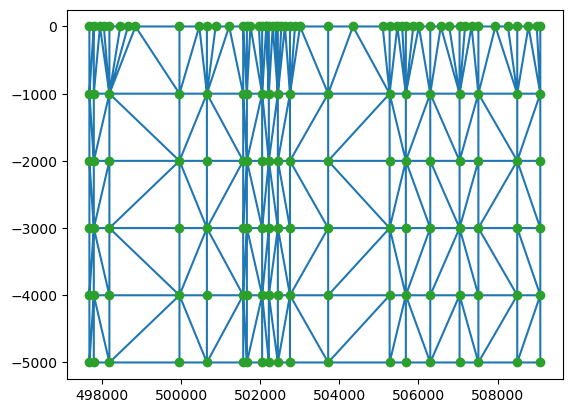

In [11]:
plt.triplot(tri.points[:,0], tri.points[:,1], tri.simplices)
plt.plot(tri.points[:,0], tri.points[:,1], 'o')
plt.show()

## Make slip

 Max a slip distribution with max slip at 4 km depth, pin surface end slip at 2 m above that point, and the other corners at 0

 Interpolate with an rbf from scipy: 

 'gaussian': exp(-(r/self.epsilon)**2)

 Where epsilon: "Adjustable constant for gaussian or multiquadrics functions - defaults to approximate average distance between nodes (which is a good start)."

In [12]:
max_slip_pt = pts[((pts[:,0]==pts[:,0].min())& (pts[:,2]==-5000))][0] 
surf_slip_pt = pts[(pts[:,0]==pts[:,0].min()) & (pts[:,2]==0)][0]
# Deepest, Northeast point
min_slip_pt = pts[(pts[:,0]==pts[:,0].max()) & (pts[:,2]==pts[:,2].max())][0]
max_slip_pt, surf_slip_pt, min_slip_pt, 

(array([ 497678.1761208 , 3939690.19444221,   -5000.        ]),
 array([ 497678.1761208 , 3939690.19444221,       0.        ]),
 array([ 509081.78566594, 3940125.72603039,       0.        ]))

In [15]:
import numpy as np
from scipy.interpolate import Rbf
# 
rbfi = Rbf([max_slip_pt[0],surf_slip_pt[0],min_slip_pt[0]], 
           [max_slip_pt[1],surf_slip_pt[1],min_slip_pt[1]], 
           [max_slip_pt[2],surf_slip_pt[2],min_slip_pt[2]], 
           [4,2,0],function='gaussian',epsilon=8000)  # radial basis function interpolator instance
di = rbfi(centroids[:,0], centroids[:,1], centroids[:,2])   # interpolated values
di.shape

(212,)

In [17]:
max(di), min(di)

(3.9449908555145456, 0.02608320893358633)

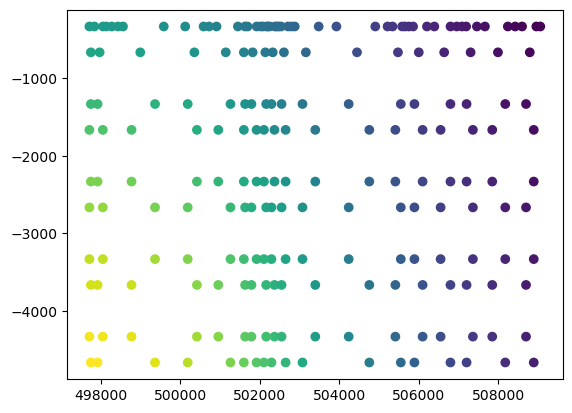

In [10]:
plt.scatter(centroids[:,0],centroids[:,2],c=di)


In [11]:
# define an observation grid at surface
ulf = min(pts[:,0]), max(pts[:,1])+500
lrf = max(pts[:,0]), min(pts[:,1])-500
xsf = np.arange(ulf[0],lrf[0],0.5)
ysf = np.arange(lrf[1],ulf[1],0.5)
obs_gridfine = np.meshgrid(xsf,ysf)


ulc = min(pts[:,0]), pts[pts[:,0]==min(pts[:,0])][0,1]+5000
lrc = max(pts[:,0]), pts[pts[:,0]==max(pts[:,0])][0,1]-5000
xsc = np.arange(ulc[0],lrc[0],100)
ysc = np.arange(lrc[1],ulc[1],100)
obs_gridcoarse = np.meshgrid(xsc,ysc)



In [12]:
len(obs_gridfine[0].flatten())/3

34990.666666666664

In [13]:
obs_points = np.concatenate([np.column_stack([obs_gridcoarse[0].flatten(),obs_gridcoarse[1].flatten(),np.zeros(len(obs_gridcoarse[0].flatten()))]),
                           np.column_stack([obs_gridfine[0].flatten(),obs_gridfine[1].flatten(),np.zeros(len(obs_gridfine[0].flatten()))])])

In [19]:
#!gdalwarp -overwrite -srcnodata 0 -r near -tr  0.5  0.5 -te 497678.1761208036 3935125.726030385 509081.78566594014 3944690.1944422117 -of GTiff /Users/chanagan/Desktop/DGStereo/Garlock/metashape/EastProducts/orthophotos/23SEP05214604-P1BS_R2C1-016332977010_01_P001.tif /Users/chanagan/Desktop/DGStereo/Garlock/metashape/EastProducts/orthophotos/23SEP05214604-P1BS_R3C1-016332977010_01_P001.tif /Users/chanagan/Desktop/DGStereo/Garlock/metashape/EastProducts/orthophotos/23SEP05214604-P1BS_R3C1-merged.tif
#!gdalwarp -overwrite -srcnodata 0 -r near -tr  0.5  0.5 -te 497678.1761208036 3935125.726030385 509081.78566594014 3944690.1944422117 -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/metashape/EastProducts/orthophotos/23SEP05214655-P1BS_R2C1-016332977010_01_P001.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/metashape/EastProducts/orthophotos/23SEP05214655-P1BS_R3C1-016332977010_01_P001.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/metashape/EastProducts/orthophotos/23SEP05214655-P1BS_R4C1-016332977010_01_P001.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/metashape/EastProducts/orthophotos/23SEP05214655-P1BS_R3C1-merged.tif
#!gdalwarp -overwrite -srcnodata 0 -r near -tr  0.5  0.5 -te 497678.1761208036 3935125.726030385 509081.78566594014 3944690.1944422117 -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/metashape/EastProducts/dems/2023GarlockEastDEM.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/metashape/EastProducts/dems/2023GarlockEastDEM-cropped.tif

#!gdalwarp -overwrite -srcnodata 0 -r near -tr  0.5  0.5 -te 497678.1761208036 3935125.726030385 509081.78566594014 3944690.1944422117 -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/metashape/EastProducts/dems/2020GarlockEastDEM.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/metashape/EastProducts/dems/2020GarlockEastDEM-cropped.tif
#!gdalwarp -overwrite -srcnodata 0 -r near -tr  0.5  0.5 -te 497678.1761208036 3935125.726030385 509081.78566594014 3944690.1944422117 -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/metashape/EastProducts/orthophotos/20APR28214017-P1BS_R2C1-016332976010_01_P001.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/metashape/EastProducts/orthophotos/20APR28214017-P1BS_R3C1-016332976010_01_P001.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/metashape/EastProducts/orthophotos/20APR28214017-P1BS_R3C1-merged.tif 
#!gdalwarp -overwrite -srcnodata 0 -r near -tr  0.5  0.5 -te 497678.1761208036 3935125.726030385 509081.78566594014 3944690.1944422117 -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/metashape/EastProducts/orthophotos/20APR28214111-P1BS_R2C1-016332976010_01_P001.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/metashape/EastProducts/orthophotos/20APR28214111-P1BS_R3C1-016332976010_01_P001.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/metashape/EastProducts/orthophotos/20APR28214111-P1BS_R3C1-merged.tif

Creating output file that is 22807P x 19129L.
Processing /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/metashape/EastProducts/dems/2020GarlockEastDEM.tif [1/1] : 0Copying nodata values from source /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/metashape/EastProducts/dems/2020GarlockEastDEM.tif to destination /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/metashape/EastProducts/dems/2020GarlockEastDEM-cropped.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [3]:
im = gdal.Open('/Users/chanagan/Desktop/DGStereo/Garlock/metashape/EastProducts/orthophotos/23SEP05214604-P1BS_R3C1-merged.tif')


/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [4]:
gt = im.GetGeoTransform()
bounds = tt.getOutputBounds(im)

In [18]:
DONT RUN unless you need to do-over!! Takes forever,
#generate half-space displacements and strains at two points
obs=obs_points

# initiate
i=0
tri = triangles[i]
ss = [di[i]]
ds = np.zeros(len(ss))
op = np.zeros(len(ss))
slip=[ss,ds,op]
nu=0.25
displ = tdcalc.TDdispHS(obs,tri,slip,nu)

for i in range(1,len(triangles)):
    print(i)
    tri = triangles[i]
    ss = [di[i]]
    ds = np.zeros(len(ss))
    op = np.zeros(len(ss))
    slip=[ss,ds,op]
    displ += tdcalc.TDdispHS(obs,tri,slip,nu)

print('displ',displ, np.shape(displ))
df = pd.DataFrame(np.column_stack([obs,displ]),columns=['x','y','z','dx','dy','dz'])
df.to_csv('bigdispl.txt')


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
displ [[ 0.18497604  0.21248494 -0.03626362]
 [ 0.17971528  0.17127422 -0.02906232]
 [ 0.1817464   0.10886374 -0.01704036]
 ...
 [-0.01158945 -0.08917925 -0.00434335]
 [-0.01136758 -0.08898968 -0.00434753]
 [-0.01114956 -0.08879384 -0.00434865]] (105092, 3)


## Interpolate deformation field and deform the rasters

In [6]:
import pygmt
import pandas as pd
import numpy as np
from osgeo import gdal
import rioxarray
import pygmt
import sys
sys.path.append('/Users/chanagan/Documents/GitHub/ImageryResources/Functions/')
import TiffTools as tt

In [7]:
df = pd.read_csv('bigdispl.txt',index_col=0)

In [8]:
im = rioxarray.open_rasterio(projfolder+'metashape/EastProducts/orthophotos/23SEP05214604-P1BS_R3C1-merged.tif')
gdalim = gdal.Open(projfolder+'metashape/EastProducts/orthophotos/23SEP05214604-P1BS_R3C1-merged.tif')
imgrid = np.meshgrid(im.x.data,im.y.data)

/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [9]:
bounds = tt.getOutputBounds(gdalim)
proj = im.spatial_ref.crs_wkt

In [7]:
Dont rerun
gridX = pygmt.xyz2grd(x=df.x.values,y=df.y.values,z=df.dx.values,
                      spacing=[0.5],
                      region=[bounds[0],bounds[2],bounds[3],bounds[1]])
gridXinterp = gridX.interpolate_na(dim='x',method='slinear').interpolate_na(dim='y',method='slinear')
gridXinterp.rio.to_raster(projfolder+'Deformation/EastdX-rio.tif',spatial_ref=proj,driver='Gtiff')


In [8]:
Dont rerun
gridY = pygmt.xyz2grd(x=df.x.values,y=df.y.values,z=df.dy.values,
                      spacing=[0.5],
                      region=[bounds[0],bounds[2],bounds[3],bounds[1]])
gridYinterp = gridY.interpolate_na(dim='x',method='slinear').interpolate_na(dim='y',method='slinear')
gridYinterp.rio.to_raster(projfolder+'Deformation/EastdY-rio.tif',spatial_ref=proj)


In [24]:
Dont rerun
gridZ = pygmt.xyz2grd(x=df.x.values,y=df.y.values,z=df.dz.values,
                      spacing=[0.5],
                      region=[bounds[0],bounds[2],bounds[3],bounds[1]])
gridZinterp = gridZ.interpolate_na(dim='x',method='slinear').interpolate_na(dim='y',method='slinear')
gridZinterp.rio.to_raster(projfolder+'Deformation/EastdZ-rio.tif',spatial_ref=proj)


In [10]:
imx = rioxarray.open_rasterio(projfolder+'Deformation/EastdX-rio.tif')
imy = rioxarray.open_rasterio(projfolder+'Deformation/EastdY-rio.tif')
imz = rioxarray.open_rasterio(projfolder+'Deformation/EastdZ-rio.tif')
#imelev = rioxarray.open_rasterio(projfolder+'metashape/EastProducts/dems/2023GarlockEastDEM-cropped.tif)
imgrid = np.meshgrid(imx.x,imx.y)

In [11]:
# y coords are flipped about the x-axis from the orthophoto coords
dx = imx.data[0]
dy = imy.data[0]
dz = imz.data[0]

In [12]:
# Sample points at deformed locations
newx = imgrid[0]-dx
newy = imgrid[1]-dy
new_points = np.column_stack([newx.flatten(),newy.flatten()])
old_points = np.column_stack([imgrid[0].flatten(),imgrid[1].flatten()])

# Identify rows containing NaN entries
nan_indices = np.isnan(new_points).any(axis=1)

# Drop rows with NaN entries
points_without_nan = new_points[~nan_indices]
old_points_without_nan = old_points[~nan_indices]

In [13]:
# see interpolation; Default uses “natural” conditions (second partial derivative normal to edge is zero) unless the grid is automatically recognized as periodic.
deformed1 = pygmt.grdtrack(projfolder+'metashape/EastProducts/orthophotos/23SEP05214604-P1BS_R3C1-merged.tif',
                          points=points_without_nan,no_skip=True)
deformed2 = pygmt.grdtrack(projfolder+'metashape/EastProducts/orthophotos/23SEP05214655-P1BS_R3C1-merged.tif',
                          points=points_without_nan,no_skip=True)
# DEM
deformedDEM = pygmt.grdtrack(projfolder+'metashape/EastProducts/dems/2023GarlockEastDEM-cropped.tif',
                          points=points_without_nan,no_skip=True)

grdtrack [WARNING]: Some input points were outside the grid domain(s).


In [13]:
deformed1.columns = ['x','y','vals']
deformed2.columns = ['x','y','vals']
deformedDEM.columns = ['x','y','vals']

NameError: name 'deformed' is not defined

In [15]:
deformed1['oldx'] = old_points_without_nan[:,0]
deformed1['oldy'] = old_points_without_nan[:,1]
deformed2['oldx'] = old_points_without_nan[:,0]
deformed2['oldy'] = old_points_without_nan[:,1]
deformedDEM['oldx'] = old_points_without_nan[:,0]
deformedDEM['oldy'] = old_points_without_nan[:,1]

In [16]:
deformed1Grid = pygmt.xyz2grd(x=deformed1.oldx.values,y=deformed1.oldy.values,z=deformed1.vals.values,
                      spacing='0.5/0.5',
                      region=[bounds[0],bounds[2],bounds[3],bounds[1]])
deformed2Grid = pygmt.xyz2grd(x=deformed2.oldx.values,y=deformed2.oldy.values,z=deformed2.vals.values,
                      spacing='0.5/0.5',
                      region=[bounds[0],bounds[2],bounds[3],bounds[1]])
deformedDEMGrid = pygmt.xyz2grd(x=deformedDEM.oldx.values,y=deformedDEM.oldy.values,z=deformedDEM.vals.values,
                      spacing='0.5/0.5',
                      region=[bounds[0],bounds[2],bounds[3],bounds[1]])

In [17]:
deformed1Grid.rio.to_raster(projfolder+'Deformation/2023deformed04ortho-rio.tif',spatial_ref=proj)
deformed2Grid.rio.to_raster(projfolder+'Deformation/2023deformed55ortho-rio.tif',spatial_ref=proj)
deformedDEMGrid.rio.to_raster(projfolder+'Deformation/2023deformedDEM-rio.tif',spatial_ref=proj)